In [1]:
#%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression # importa o modelo
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import sklearn.manifold as skm
from sklearn import metrics
import scipy.stats as stats
import seaborn as sns
import random as rdn
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import time

## Reading Dataset

In [2]:
# setting names to columns after read csv file
data_column_names = ["Date", "Time", "Epoch", "Moteid", "Temperature", "Humidity", "Light", "Voltage"]
data = pd.read_csv("dataset/data.txt", delimiter = " ", names = data_column_names)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313682 entries, 0 to 2313681
Data columns (total 8 columns):
Date           object
Time           object
Epoch          int64
Moteid         float64
Temperature    float64
Humidity       float64
Light          float64
Voltage        float64
dtypes: float64(5), int64(1), object(2)
memory usage: 141.2+ MB


### Filter Dataset
> Definning the dataset with only epochs in [2, 5576]

In [4]:
data = data[(data["Epoch"] <= 5576) & (data["Epoch"] > 1)] 

### Missing Data

> Plotting Missing Data

Text(0,0.5,'Percentage')

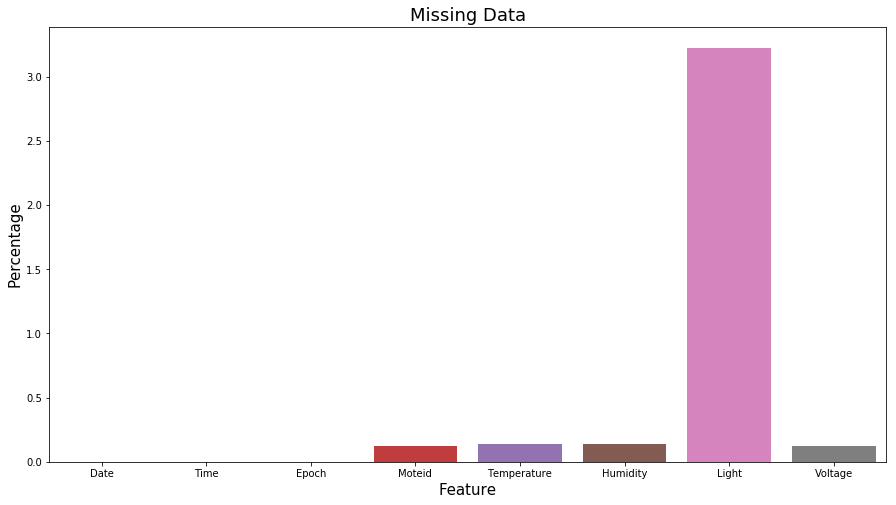

In [5]:
missing = pd.DataFrame((data.isnull().sum() * 100 )/ data.shape[0]).reset_index().rename(columns = {'index': 'Feature', 0: 'Percent'})
p = sns.barplot(x = 'Feature', y = 'Percent', data = missing, ax = plt.subplots(figsize = (15, 8))[1])
p.set_title('Missing Data', fontsize = 18)
p.set_xlabel('Feature', fontsize = 15)
p.set_ylabel('Percentage', fontsize = 15)

> Change features order

In [6]:
data = data[["Moteid", "Epoch", "Humidity", "Light", "Voltage", "Date", "Time", "Temperature"]]

## Applying changes in dataset

#### Creating a dataframe $means\_epochs$, where epoch in [2, 5576] and feature in ["Temperature", "Humidity", "Light", "Voltage"]

In [7]:
epocas = np.sort(data["Epoch"].unique()) #sorting epochs list
means = {"Temperature": [], "Humidity": [], "Light": [], "Voltage": []} # dict of means

# percorrendo as features
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    for epoch in epocas:
        means[feature].append(data[data['Epoch'] == epoch][feature].mean())

# creating dataframe with means
means_epochs = pd.DataFrame(means).set_index(epocas).reset_index().rename(columns = {'index': 'Epoch'})

### _Step 1 in Pre-processing_

#### Replacing missing data by mean combining feature $f_i$ and epoch $epo_i$

In [8]:
# parsing in the features
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    # first epoch
    aux = data[data['Epoch'] == 2].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 3][feature].values[0]
    
    # last epoch
    aux = data[data['Epoch'] == 5576].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 5575][feature].values[0]
    
    for epoch in range(1, len(epocas) - 1):
        aux = data[data['Epoch'] == epocas[epoch]].copy()
        index_ = aux[aux[feature].isnull()].index
        
        data.loc[index_, feature] = (means_epochs[means_epochs['Epoch'] == epocas[epoch - 1]][feature].values[0] + \
                                    means_epochs[means_epochs['Epoch'] == epocas[epoch + 1]][feature].values[0]) / 2        

In [9]:
outliers = data.copy() # copying the data to compare after

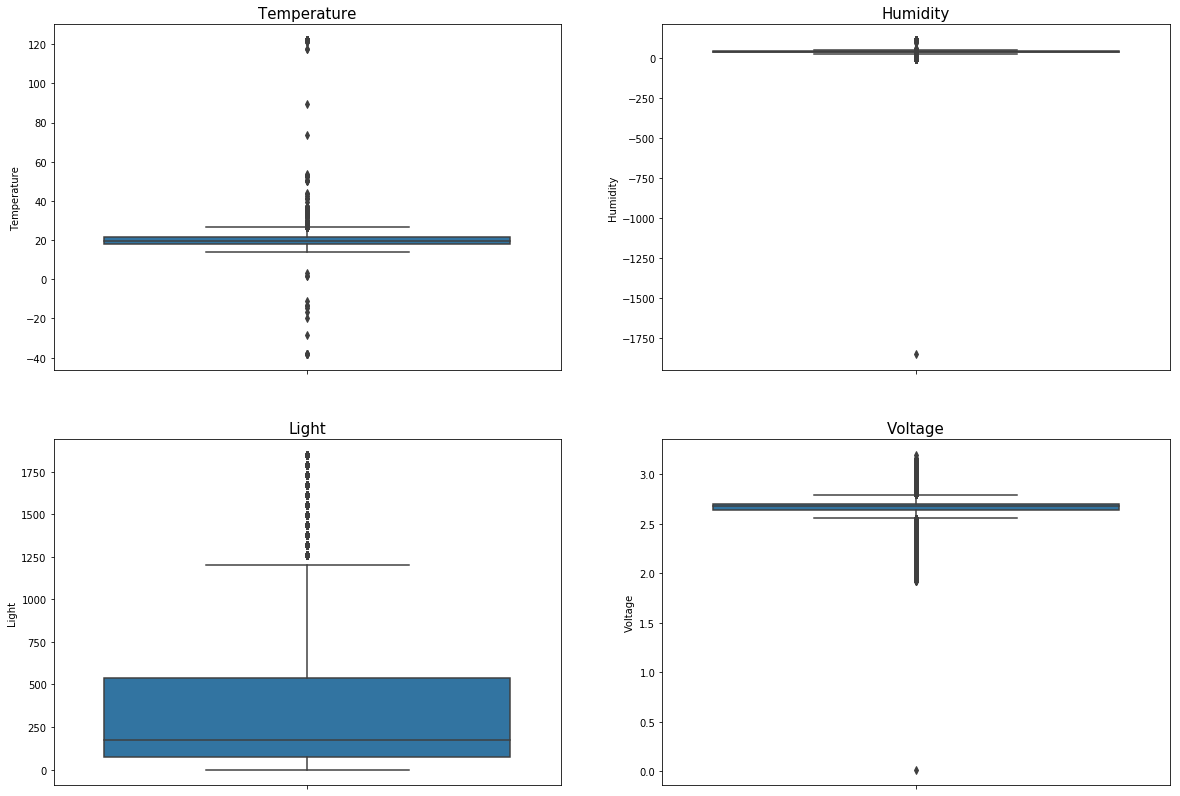

In [10]:
# plotting outliers
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = outliers, ax = ax[i, j])
        indx += 1

#### Replacing outliers


> Replacing rows with values $\notin$ $[-3\sigma + \mu , \mu + 3\sigma]$ by $\mu$

In [11]:
#https://pt.wikipedia.org/wiki/Amplitude_interquartil

#for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
#    data = data[np.abs(data[feature] - data[feature].mean()) <= 3 * data[feature].std()].copy()

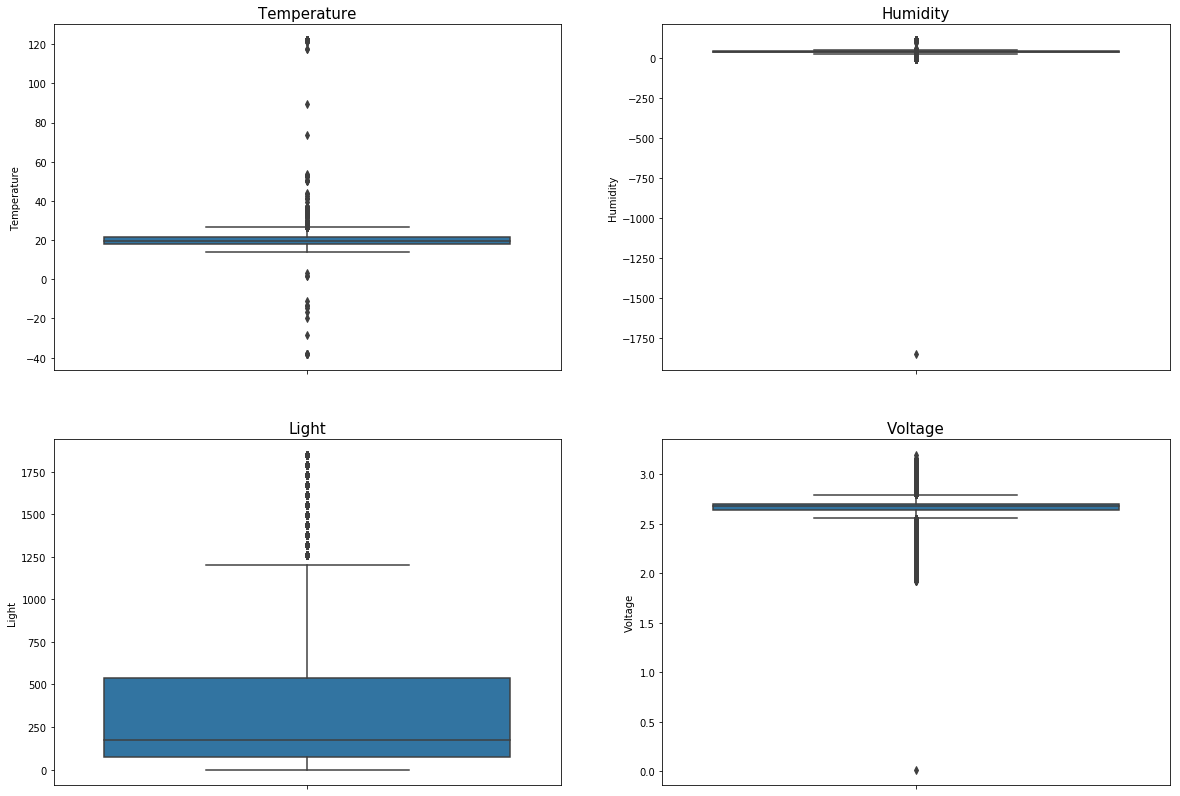

In [12]:
# plotting outliers
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = data, ax = ax[i, j])
        indx += 1

In [14]:
print("Amount of rows")
print("before removing outliers: {}".format(outliers.shape[0]))
print("after removing outliers: {}".format(data.shape[0]))

Amount of rows
before removing outliers: 188392
after removing outliers: 188392


> OBS.: `Light` didn't change

### `Light` Distribution

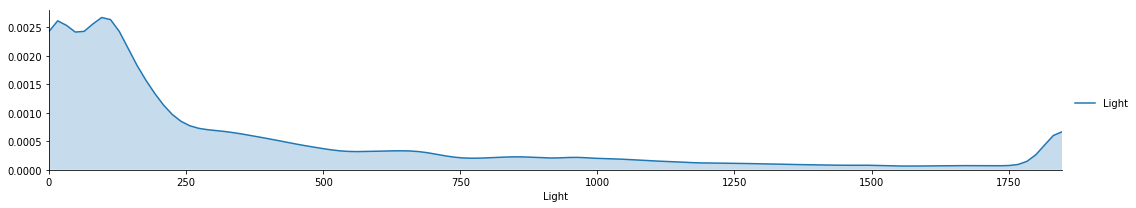

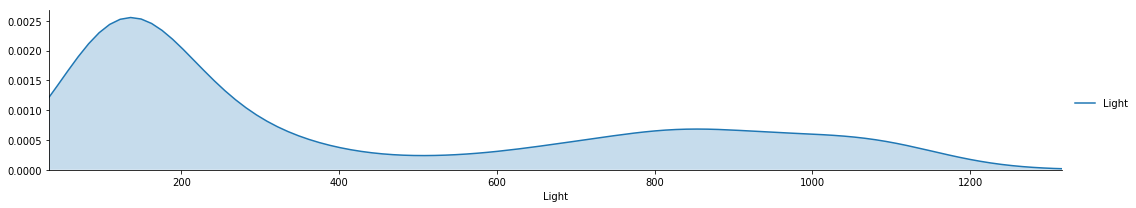

In [15]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Light', shade=True)
facet.set(xlim=(data["Light"].min(), data["Light"].max()))
facet.add_legend()

facet = sns.FacetGrid(means_epochs, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Light', shade=True)
facet.set(xlim=(means_epochs["Light"].min(), means_epochs["Light"].max()))
facet.add_legend()

### _Step 2 in Pre-processing_

#### Removing outliers 10%

In [16]:
for epo in epocas:
    for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
        
        mean_ = means_epochs.query('Epoch == {}'.format(epo))[feature].values[0]
        index_data = data[data['Epoch'] == epo][feature].index
        
        for ind in range(1, len(index_data)):
            variation = np.abs(data.loc[index_data[ind - 1], feature] - data.loc[index_data[ind], feature])/data.loc[index_data[ind - 1], feature]
            if variation > 0.1:
                data.loc[index_data[ind], feature] = mean_

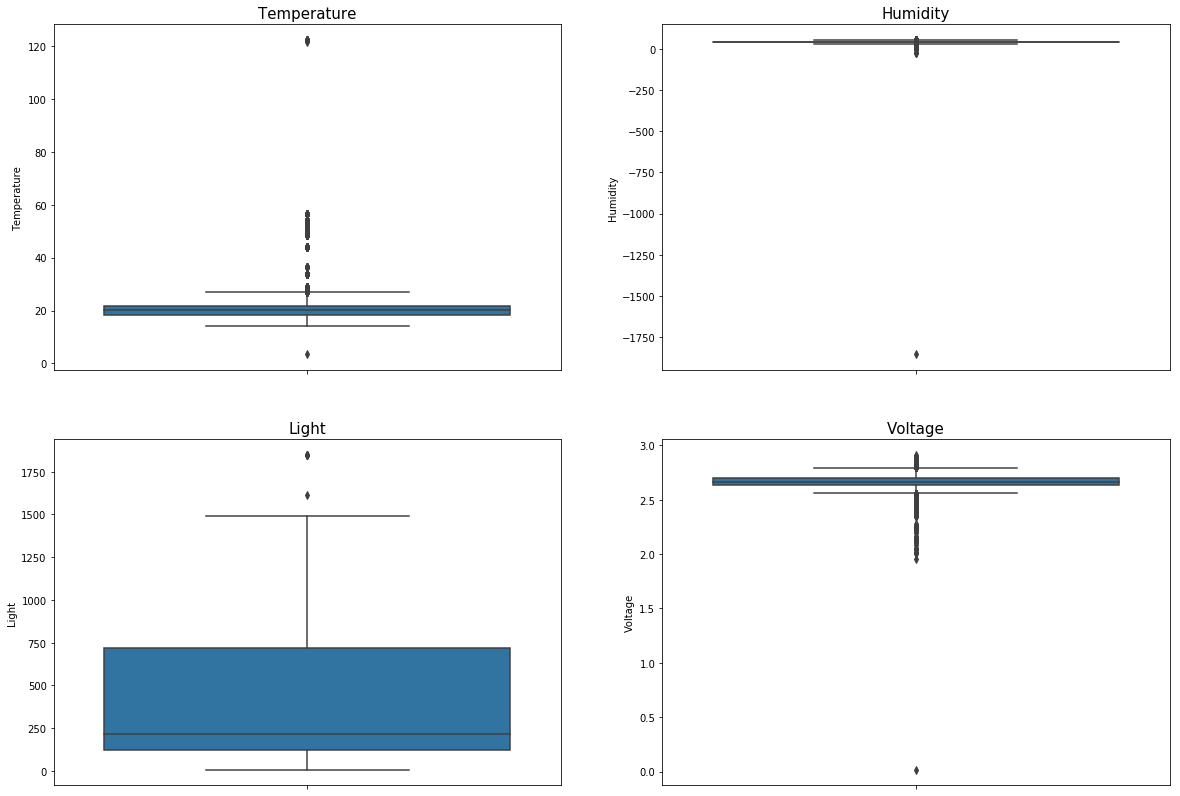

In [17]:
#for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
#    data = data[np.abs(data[feature] - data[feature].mean()) <= 3 * data[feature].std()].copy()

# plotting outliers
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = data, ax = ax[i, j])
        indx += 1

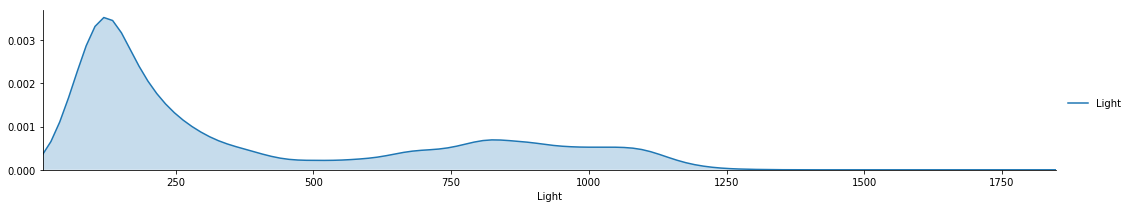

In [18]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Light', shade=True)
facet.set(xlim=(data["Light"].min(), data["Light"].max()))
facet.add_legend()

In [19]:
print("Amount of rows in the final: {}".format(data.shape[0]))

Amount of rows in the final: 188392


## Creating a model

### Reading the localization of sensor in the lab

In [20]:
sensors = pd.read_csv("http://db.csail.mit.edu/labdata/mote_locs.txt", sep = " ", names = ['Moteid', 'X', 'Y'])

In [21]:
# adding coordanates in the dataset
data_ = pd.merge(data, sensors, how='left', on='Moteid' )
data_ = data_[~(data_['X'].isnull()) | ~(data_['Y'].isnull())] # removing null lines

data_.to_pickle("dataset/bin/data.pkl")

#### *Reading Pickle Dataset*

In [ ]:
#data_ = pd.read_pickle("dataset/bin/data.pkl")

### Parsing a Leave - out

In [59]:
features_ = []

for feature in ["Temperature", "Humidity", "Voltage", "Light"]:
    epochs_error_mean = []
    epochs_error_sqrt = []
    
    for ep in epochs:
        
        X_train, y_train = data_[data_['Epoch'] != ep][['X', 'Y']], data_[data_['Epoch'] != ep][feature]
        X_test, y_test = data_[data_['Epoch'] == ep][['X', 'Y']], data_[data_['Epoch'] == ep][feature]
        
        regr = LinearRegression()
        regr.fit(X_train, y_train) # fitting model

        y_pred = regr.predict(X_test)
        error = mean_squared_error(y_test, y_pred)

        epochs_error_mean.append(error) # array of mean squared errors
        epochs_error_sqrt.append(np.sqrt(error)) # array of sqrt mean squared error
    
    features_.append(epochs_error_mean)
    
#epochs_error_mean
epoch_features_error = pd.DataFrame(np.array(features_).T, columns = ['Loc~Temp', 'Loc~Humidity', 'Loc~Voltage', 'Loc~Light']).set_index(epochs).reset_index().rename(columns = {'index': 'Epoch'})
#np.array(features_).shape

In [75]:
epoch_features_error.describe()

,Epoch,Loc~Temp,Loc~Humidity,Loc~Voltage,Loc~Light
count,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000
mean,2789.000000,8.890135,41.974845,0.004121,125113.329807
std,1609.508206,58.540719,1723.976271,0.004273,130022.468406
min,2.000000,0.153547,0.777962,0.000566,144.106272
25%,1395.500000,1.467262,3.578491,0.002956,47962.380285
50%,2789.000000,4.041110,8.363039,0.003610,78757.052763
75%,4182.500000,9.316063,24.796723,0.004783,136167.388705
max,5576.000000,2160.841099,128729.741438,0.253464,834442.668027


#### Instancing the model

In [55]:
epochs = np.sort(data_["Epoch"].unique()) # array of epochs

#number_ep = 2504 
#test = data_[data_['Epoch'] == number_ep].copy()
test = data_[data_['Epoch'].isin(epochs)].copy()

models = {} # a list of regression models
for feature in ["Temperature", "Humidity", "Voltage", "Light"]:
    regr = LinearRegression() # Linear Regression
    models[feature] = regr.fit(test[['X', 'Y']].values, test[feature].values)

#### Plotting 3D in Python

In [57]:
for eixo, feature in enumerate(["Temperature", "Humidity", "Voltage", "Light"]):
    
    regr = models[feature]
    #print(regr.coef_, regr.intercept_)
    
    X = []
    #for x, y in zip (data_[data_['Epoch'] == number_ep]['X'].values,  data_[data_['Epoch'] == number_ep]['Y'].values):
    for x, y in zip (test['X'].values,  test['Y'].values):
        X.append([x, y])

    X = np.array(X)
    #Z = np.array(data_[data_['Epoch'] == number_ep][feature].values)
    Z = np.array(test[feature].values)

    X_, Y_ = np.meshgrid(X[:, 0], X[:, 1])  # Criando uma malha de pontos para o plot.
    Z_hat = regr.coef_[0] * X_ + regr.coef_[1] * Y_ + regr.intercept_

    # calculating the mean sqarred error
    error = []
    for i in range(Z.shape[0]):
        error.append(Z_hat[i, i] - Z[i])

    error = np.array(error) ** 2
    error = error.mean()

    # settings
    # plot raw data
    fig = plt.figure(figsize = (30, 38))

    ax = fig.add_subplot(4, 1, eixo + 1, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], Z, marker = 'o', c = 'r')
    ax.plot_wireframe(X_, Y_, Z_hat, color = 'k')

    # creating the points of the plot
    # each column are a point
    xx = X[:, 0]
    yy = X[:, 1]
    for i in range(xx.shape[0]):
        ax.plot([xx[i], xx[i]] , [yy[i],yy[i]], [Z[i] , Z_hat[i, i]], marker="_", color = 'b')

    ax.set_title("{} Plot - $\epsilon = {}$".format(feature, round(error, 3)), fontsize = 20)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(feature)
    ax.view_init(20, -60)
    #ax.text(20, 25, ax.get_zlim()[1] - 1, r" $\epsilon = {e}$".format(e = round(error, 3)), color = 'k', fontsize =18)
    
plt.show()

MemoryError: 

In [50]:
new_data = new_data[new_data['Epoch'].isin(epochs)]

In [133]:
regr = LinearRegression()

features_ = []
for feature in ['Light', 'Voltage', 'Humidity']:
    epochs_error_mean = []
    epochs_error_sqrt = []
    for ep in epochs:
        
        X_train, y_train = new_data[new_data['Epoch'] != ep][[feature]], new_data[new_data['Epoch'] != ep]['Temperature']
        X_test, y_test = new_data[new_data['Epoch'] == ep][[feature]], new_data[new_data['Epoch'] == ep]['Temperature']

        regr.fit(X_train, y_train) # fitting model

        y_pred = regr.predict(X_test)
        error = mean_squared_error(y_test, y_pred)

        epochs_error_mean.append(error) # array of mean squared errors
        epochs_error_sqrt.append(np.sqrt(error)) # array of sqrt mean squared error
    
    features_.append(epochs_error_mean)
#epochs_error_mean
pd.DataFrame(np.array(features_).T, columns = ['Temp~Light', 'Temp~Voltage', 'Temp~Humidity']).set_index(epochs).reset_index().rename(columns = {'index': 'Epoch'})
#np.array(features_).shape

,Epoch,Temp~Light,Temp~Voltage,Temp~Humidity
0,2,3907.348593,1052.484763,665.123915
1,21,668.381371,223.623566,12.415613
2,25,666.834049,262.453161,10.083226
3,58,604.495781,150.576558,10.268495
4,61,203.860043,129.883504,11.594031


In [112]:
X2 = new_data[['Humidity']]
y2 = new_data['Temperature']
regr2 = LinearRegression()
regr2.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
new_data[new_data['Epoch'] == 2].shape

(38, 8)

In [128]:
new_data.Epoch.unique()
[143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588]

array([ 2, 21, 25, 58, 61], dtype=int64)

In [91]:
epochs_error_mean

[665.1239146876059,
 12.415612680189163,
 10.083225852101558,
 10.268495176446756,
 11.594031480074635]

In [45]:
X = new_data[['Voltage']] #'Light', 'Voltage', Humidity]]
y = new_data['Temperature']

In [46]:
# cria o modelo
regr = LinearRegression()

regr.fit(X, y) # treina o modelo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
mean_squared_error(y, regr.predict(X))

368.03406495362265

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
r2_train = regr.score(X_train, y_train)
r2_test = regr.score(X_test, y_test)
print('R2 no set de treino: %.2f' % r2_train)
print('R2 no set de teste: %.2f' % r2_test)

R2 no set de treino: 0.03
R2 no set de teste: 0.01


In [1]:
import pandas as pd
from sklearn import linear_model

#carregando dados hipotéticos, para fins didáticos apenas
dataframe = pd.DataFrame()
dataframe['x'] = [5.1, 5.5, 5.9, 6.5, 6.8, 7.6, 8.3, 8.5, 9.1, 9.5]  # horas de estudo
dataframe['y'] = [2.0, 2.9, 4.0, 5.9, 6.0, 6.9, 8.0, 9.0, 9.9, 11.0] # pontuaçao alcançada
x_values = dataframe[['x']]
y_values = dataframe[['y']]

#treinando o modelo
model = linear_model.LinearRegression()
model.fit(x_values, y_values)

#imprimindo os valores
print('Utilizando biblioteca scikit-learn no python')
print('y = ax + b')
print('a = %.2f = a inclinação da linha de tendência.' % model.coef_[0][0])
print('b = %.2f = o ponto onde a linha de tendência atinge o eixo y.' % model.intercept_[0])

Utilizando biblioteca scikit-learn no python
y = ax + b
a = 1.92 = a inclinação da linha de tendência.
b = -7.39 = o ponto onde a linha de tendência atinge o eixo y.
